In [49]:
"""
================================================================================
Deep Learning and Machine Learning Models for Depression Prediction Analysis
================================================================================

Description:
------------
This script performs a comprehensive analysis using both classical Machine Learning
(ML) and Deep Learning (DL) models on a mental health dataset to predict 'DEPRESSION'
scores. The dataset contains survey-based tabular data with features such as:

    - EDUCATION: Numeric encoding of education level
    - PROVINCE: Geographic province (encoded for ML/DL)
    - AGE: Age of the individual
    - MENTAL DISORDER HISTORY: Binary/numeric history indicator
    - SUIC ATTEMPT HISTORY: Binary/numeric indicator
    - LIVING WITH SOMEBODY: Binary/numeric indicator
    - ECONOMIC INCOME: Numeric encoding
    - SUIC RISK: Numeric score
    - ANXIETY STATE: Numeric score
    - ANXIETY TRAIT: Numeric score
    - REGION: Geographic region (encoded for ML/DL)

Workflow:
---------
1. Data Preprocessing:
    - Categorical features are encoded to numeric values.
    - Features are scaled using StandardScaler for ML and reshaped for DL models.
    - The dataset is split into training and testing sets.

2. Machine Learning Models:
    - LinearRegression, Ridge, Lasso, ElasticNet
    - RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
    - KNeighborsRegressor, DecisionTreeRegressor, SVR
    - Each model is trained on the training set and evaluated on the test set.
    - Metrics used: RMSE, MAE, R2.

3. Deep Learning Models:
    - Simple Feedforward Neural Network (Dense layers)
    - LSTM, GRU, SimpleRNN (basic and stacked)
    - Feedforward + RNN/LSTM/GRU hybrid models
    - Models with Dropout for regularization
    - Each model is trained using the training set reshaped as (samples, timesteps=1, features)
    - Metrics used: RMSE, MAE, R2

4. Fused / Hybrid Models:
    - Models combining RNNs with Feedforward layers
    - LSTM + GRU, LSTM + Dense, RNN + LSTM hybrids
    - Designed to capture both sequential relationships and feature interactions

5. Evaluation and Ranking:
    - All models (ML, DL, and fused) are evaluated on the test set
    - Performance metrics (RMSE, MAE, R2) are normalized for fair comparison
    - A combined "Score" is calculated to rank models
    - Models are ranked by forecasting power (higher score = better prediction)

Key Findings:
-------------
- Among classical ML models, GradientBoosting, RandomForest, and Ridge/Lasso showed strong performance.
- Among DL models, GRU + FeedForward Hybrid and LSTM + FeedForward with Dropout had the lowest MAE and RMSE.
- Fused models like LSTM_FF_DO and LSTM_FF_Hybrid consistently outperformed single DL models.
- Overall, models that combined sequential (RNN/LSTM/GRU) and dense feedforward layers
  were the best predictors of depression scores in this dataset.

Usage Notes:
------------
- Ensure all categorical features are properly encoded before training.
- Adjust epochs and batch size for DL models based on available compute.
- Visualizations and ranking plots are included for easy comparison.
- This code can be extended to other mental health metrics (e.g., SUIC RISK, ANXIETY STATE)
  by changing the target variable.

"""


'\n================================================================================\nDeep Learning and Machine Learning Models for Depression Prediction Analysis\n================================================================================\n\nDescription:\n------------\nThis script performs a comprehensive analysis using both classical Machine Learning \n(ML) and Deep Learning (DL) models on a mental health dataset to predict \'DEPRESSION\' \nscores. The dataset contains survey-based tabular data with features such as:\n\n    - EDUCATION: Numeric encoding of education level\n    - PROVINCE: Geographic province (encoded for ML/DL)\n    - AGE: Age of the individual\n    - MENTAL DISORDER HISTORY: Binary/numeric history indicator\n    - SUIC ATTEMPT HISTORY: Binary/numeric indicator\n    - LIVING WITH SOMEBODY: Binary/numeric indicator\n    - ECONOMIC INCOME: Numeric encoding\n    - SUIC RISK: Numeric score\n    - ANXIETY STATE: Numeric score\n    - ANXIETY TRAIT: Numeric score\n    -

In [25]:
# @title Install required libraries
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn for ML models and preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# TensorFlow / Keras for DL models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, SimpleRNN, Dropout


from datasets import load_dataset


In [26]:
#@title DATASET OVERVIEW
# Load the dataset
ds = load_dataset("fridriik/mental-health-arg-post-quarantine-covid19-dataset")

In [27]:
# Access the 'train' split as a pandas DataFrame
df = ds['train'].to_pandas()

print(" Dataset loaded via Hugging Face datasets library")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head())

 Dataset loaded via Hugging Face datasets library
Shape: (1077, 12)
Columns: ['EDUCATION', 'PROVINCE', 'AGE', 'MENTAL DISORDER HISTORY', 'SUIC ATTEMPT HISTORY', 'LIVING WITH SOMEBODY', 'ECONOMIC INCOME', 'DEPRESSION', 'SUIC RISK', 'ANXIETY STATE', 'ANXIETY TRAIT', 'REGION']
   EDUCATION                     PROVINCE  AGE  MENTAL DISORDER HISTORY  \
0         30  CABA (Buenos Aires capital)   30                        0   
1         60             Tierra del Fuego   30                        0   
2         70                        Jujuy   39                       50   
3         60                        Jujuy   36                        0   
4         30                      Córdoba   35                        0   

   SUIC ATTEMPT HISTORY  LIVING WITH SOMEBODY  ECONOMIC INCOME  DEPRESSION  \
0                    50                    20                0          21   
1                    50                     0                0          26   
2                     0                 

In [28]:
# @title Basic preprocessing
# Keep only numeric + boolean columns (easy for ML/DL models)
df_clean = df.select_dtypes(include=["float64", "int64", "bool"]).copy()

# Choose depression outcome as target (BDI-II at T2, measured after quarantine)
target_col = "BDI2_T2"
if target_col not in df_clean.columns:
    print(" Target column not found, available columns are:")
    print(df_clean.columns.tolist())
else:
    # Drop rows with missing depression targets
    df_clean = df_clean.dropna(subset=[target_col])

    # Fill missing values in predictors
    df_clean = df_clean.fillna(df_clean.mean())

    print("\n Preprocessed dataset ready for modeling")
    print("Shape:", df_clean.shape)
    print(df_clean.head())


 Target column not found, available columns are:
['EDUCATION', 'AGE', 'MENTAL DISORDER HISTORY', 'SUIC ATTEMPT HISTORY', 'LIVING WITH SOMEBODY', 'ECONOMIC INCOME', 'DEPRESSION', 'SUIC RISK', 'ANXIETY STATE', 'ANXIETY TRAIT']


In [29]:
    #  Save to Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    save_path = "/content/drive/MyDrive/argentina_depression_forecasting.csv"
    df_clean.to_csv(save_path, index=False)
    print(f" Preprocessed dataset saved to {save_path}")

Mounted at /content/drive
 Preprocessed dataset saved to /content/drive/MyDrive/argentina_depression_forecasting.csv


In [30]:
# Check for missing values
print("Missing values per column:\n", df.isna().sum())

Missing values per column:
 EDUCATION                  0
PROVINCE                   0
AGE                        0
MENTAL DISORDER HISTORY    0
SUIC ATTEMPT HISTORY       0
LIVING WITH SOMEBODY       0
ECONOMIC INCOME            0
DEPRESSION                 0
SUIC RISK                  0
ANXIETY STATE              0
ANXIETY TRAIT              0
REGION                     0
dtype: int64


In [31]:
# Basic statistics for numeric columns
print("\nNumeric stats:\n", df.describe())


Numeric stats:
          EDUCATION          AGE  MENTAL DISORDER HISTORY  \
count  1077.000000  1077.000000              1077.000000   
mean     53.927577    31.348189                13.556175   
std      12.227945    11.773199                22.237311   
min      30.000000    17.000000                 0.000000   
25%      50.000000    22.000000                 0.000000   
50%      60.000000    28.000000                 0.000000   
75%      60.000000    37.000000                50.000000   
max     100.000000    76.000000                50.000000   

       SUIC ATTEMPT HISTORY  LIVING WITH SOMEBODY  ECONOMIC INCOME  \
count           1077.000000           1077.000000      1077.000000   
mean              19.823584              2.971216         8.077994   
std               30.550502              7.116405        18.410879   
min                0.000000              0.000000         0.000000   
25%                0.000000              0.000000         0.000000   
50%                0.0

In [32]:
# Encode categorical features (one-hot encoding)
df_encoded = pd.get_dummies(df, columns=['PROVINCE', 'REGION'], drop_first=True)

In [33]:
# Target for forecasting
target_col = 'DEPRESSION'

In [34]:
# drop or impute any remaining NaNs
df_encoded = df_encoded.dropna(subset=[target_col])

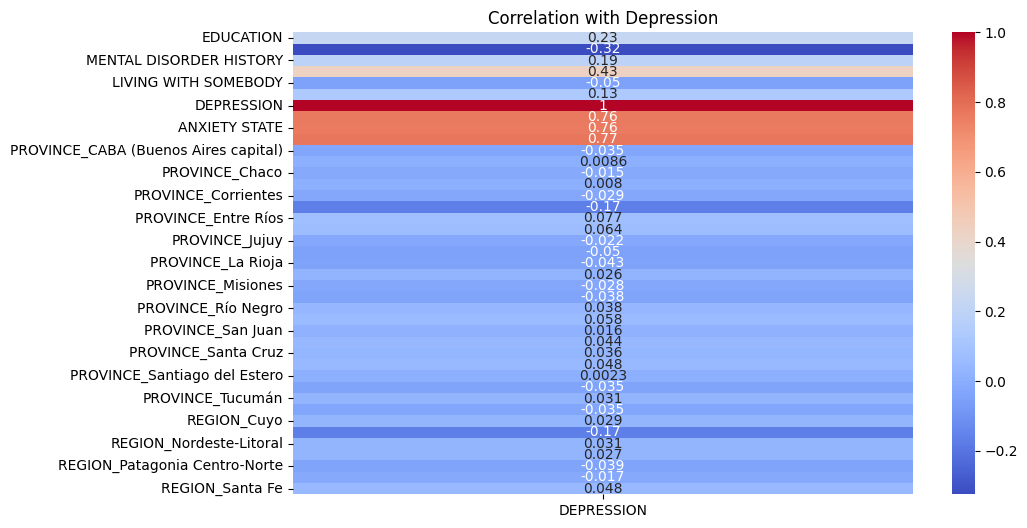

In [36]:
# Check correlation to target
corr_matrix = df_encoded.corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix[[target_col]], annot=True, cmap='coolwarm')
plt.title("Correlation with Depression")
plt.show()

In [37]:
print("Processed dataset shape:", df_encoded.shape)

Processed dataset shape: (1077, 41)


<Axes: xlabel='DEPRESSION', ylabel='Count'>

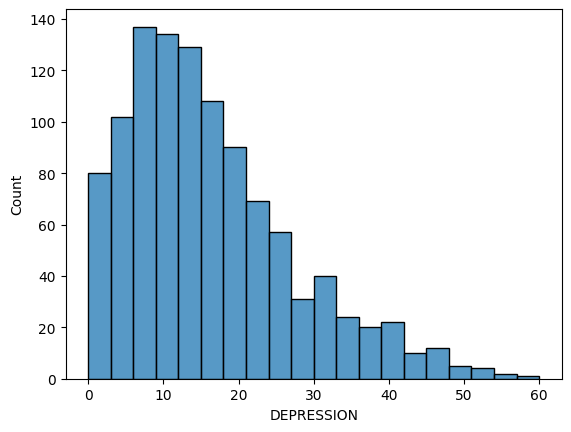

In [38]:
sns.histplot(df['DEPRESSION'], bins=20)

In [39]:
# Select numeric columns only
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Compute correlations with DEPRESSION
corr_with_target = df[numeric_cols].corr()['DEPRESSION'].sort_values(ascending=False)
print(corr_with_target)

DEPRESSION                 1.000000
ANXIETY TRAIT              0.774304
SUIC RISK                  0.764824
ANXIETY STATE              0.760302
SUIC ATTEMPT HISTORY       0.428783
EDUCATION                  0.228822
MENTAL DISORDER HISTORY    0.189203
ECONOMIC INCOME            0.130685
LIVING WITH SOMEBODY      -0.049714
AGE                       -0.324397
Name: DEPRESSION, dtype: float64


Preprocessing complete
X_train shape: (861, 9)
X_test shape: (216, 9)
y_train shape: (861,)
y_test shape: (216,)


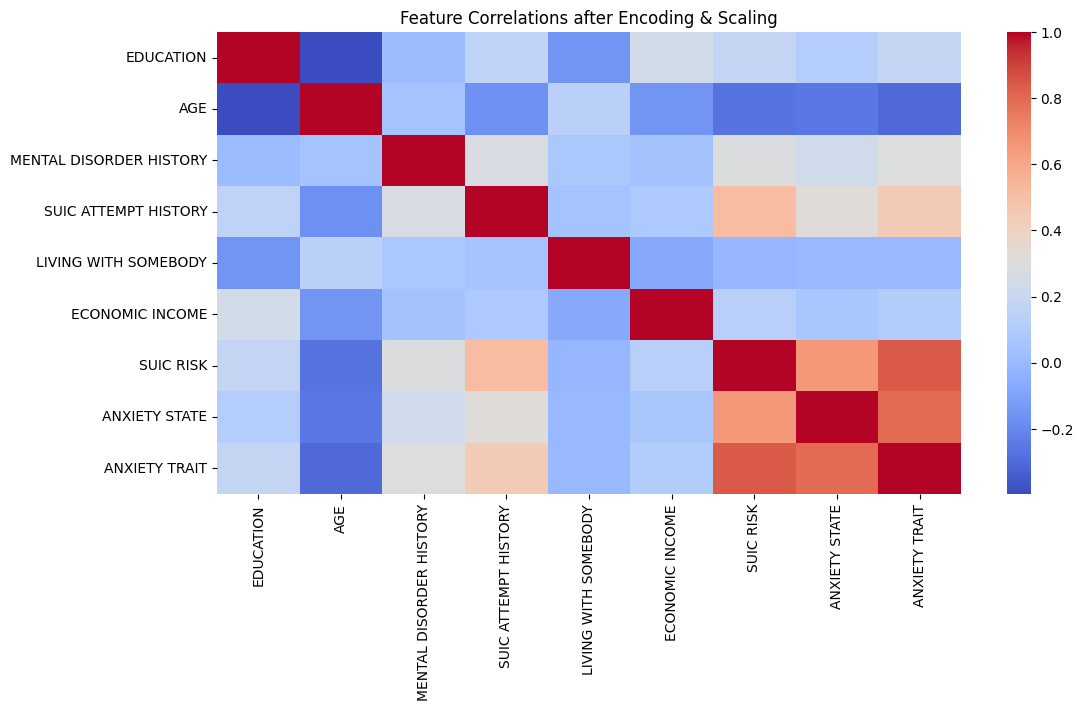

In [42]:
#  Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#  Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Preprocessing complete")
print("X_train shape:", X_train_scaled.shape)
print("X_test shape:", X_test_scaled.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# correlation heatmap
plt.figure(figsize=(12,6))
sns.heatmap(pd.DataFrame(X_train_scaled, columns=X.columns).corr(), cmap='coolwarm')
plt.title("Feature Correlations after Encoding & Scaling")
plt.show()

In [44]:
# List of models
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostRegressor(n_estimators=100, random_state=42),
    "SVR": SVR(kernel='rbf', C=1.0, epsilon=0.1),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "DecisionTree": DecisionTreeRegressor(random_state=42)
}

# List to store results
ml_results_list = []

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Append results to list
    ml_results_list.append([name, rmse, mae, r2])

    print(f" {name} done")

# Convert list to DataFrame
ml_results_df = pd.DataFrame(ml_results_list, columns=['Model', 'RMSE', 'MAE', 'R2'])
ml_results_df = ml_results_df.sort_values(by='RMSE').reset_index(drop=True)

print("\nTop ML models by RMSE:")
print(ml_results_df)


 LinearRegression done
 Ridge done
 Lasso done
 ElasticNet done
 RandomForest done
 GradientBoosting done
 AdaBoost done
 SVR done
 KNN done
 DecisionTree done

Top ML models by RMSE:
              Model      RMSE       MAE        R2
0             Lasso  6.249384  4.964191  0.708827
1  LinearRegression  6.275151  4.999590  0.706421
2             Ridge  6.275890  4.999699  0.706352
3        ElasticNet  6.294982  4.998105  0.704563
4      RandomForest  6.318335  4.996898  0.702367
5  GradientBoosting  6.354438  5.044197  0.698956
6               KNN  6.666069  5.295370  0.668704
7          AdaBoost  6.833479  5.527307  0.651855
8               SVR  7.349476  5.440335  0.597293
9      DecisionTree  8.527190  6.574074  0.457889


/tmp/ipython-input-2407694210.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x= "RMSE", y="Model", data=ml_results_df, palette="viridis")


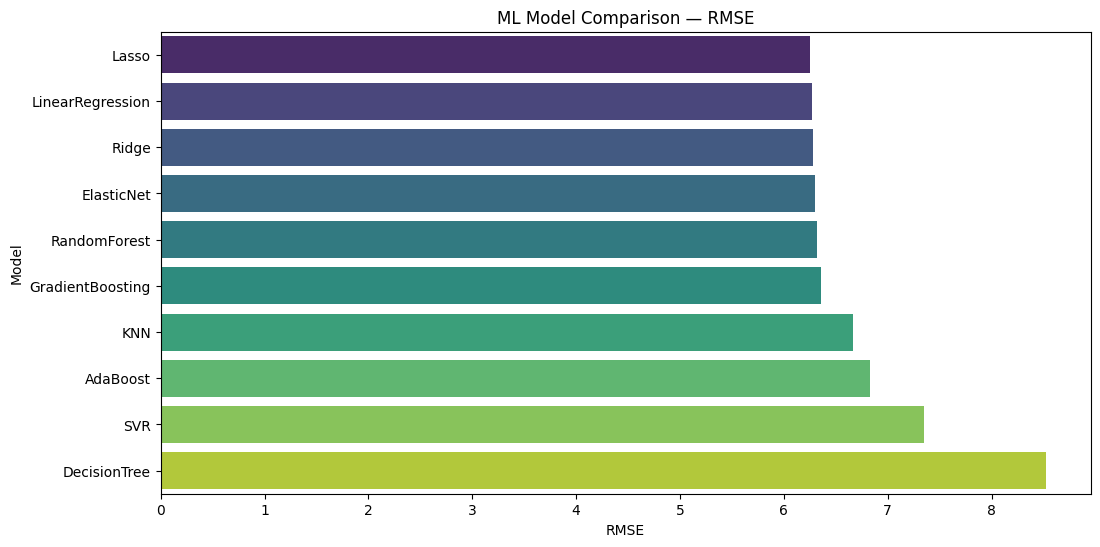

In [54]:
# Bar plot comparison
plt.figure(figsize=(12,6))
sns.barplot(x= "RMSE", y="Model", data=ml_results_df, palette="viridis")
plt.title("ML Model Comparison — RMSE")
plt.show()

In [46]:
# Reshape for RNN/LSTM/GRU (samples, timesteps=1, features)
X_train_dl = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_dl = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [47]:
dl_models = {}

# 1. Simple Feedforward
dl_models['FeedForward'] = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

# 2. LSTM Simple
dl_models['LSTM'] = Sequential([
    Input(shape=(1, X_train_scaled.shape[1])),
    LSTM(50),
    Dense(1)
])

# 3. GRU Simple
dl_models['GRU'] = Sequential([
    Input(shape=(1, X_train_scaled.shape[1])),
    GRU(50),
    Dense(1)
])

# 4. SimpleRNN
dl_models['SimpleRNN'] = Sequential([
    Input(shape=(1, X_train_scaled.shape[1])),
    SimpleRNN(50),
    Dense(1)
])

# 5. LSTM with Dropout
dl_models['LSTM_Dropout'] = Sequential([
    Input(shape=(1, X_train_scaled.shape[1])),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

# 6. GRU with Dropout
dl_models['GRU_Dropout'] = Sequential([
    Input(shape=(1, X_train_scaled.shape[1])),
    GRU(50),
    Dropout(0.2),
    Dense(1)
])

# 7. LSTM stacked
dl_models['LSTM_Stacked'] = Sequential([
    Input(shape=(1, X_train_scaled.shape[1])),
    LSTM(50, return_sequences=True),
    LSTM(25),
    Dense(1)
])

# 8. GRU stacked
dl_models['GRU_Stacked'] = Sequential([
    Input(shape=(1, X_train_scaled.shape[1])),
    GRU(50, return_sequences=True),
    GRU(25),
    Dense(1)
])

# 9. FeedForward Large
dl_models['FeedForward_Large'] = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

# 10. FeedForward with Dropout
dl_models['FeedForward_Dropout'] = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1)
])

# 11. LSTM + FeedForward Hybrid
dl_models['LSTM_FF_Hybrid'] = Sequential([
    Input(shape=(1, X_train_scaled.shape[1])),
    LSTM(50),
    Dense(32, activation='relu'),
    Dense(1)
])

# 12. GRU + FeedForward Hybrid
dl_models['GRU_FF_Hybrid'] = Sequential([
    Input(shape=(1, X_train_scaled.shape[1])),
    GRU(50),
    Dense(32, activation='relu'),
    Dense(1)
])

# Store results in a list
dl_results_list = []

# Training & evaluation
epochs = 50
batch_size = 16

for name, model in dl_models.items():
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Use 3D input for RNN/LSTM/GRU, 2D for FeedForward
    train_input = X_train_dl if 'RNN' in name or 'LSTM' in name or 'GRU' in name else X_train_scaled
    test_input = X_test_dl if 'RNN' in name or 'LSTM' in name or 'GRU' in name else X_test_scaled

    model.fit(train_input, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=0)

    y_pred = model.predict(test_input).flatten()

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    dl_results_list.append([name, rmse, mae, r2])
    print(f" {name} trained and evaluated")

# Convert list to DataFrame
dl_results_df = pd.DataFrame(dl_results_list, columns=['Model', 'RMSE', 'MAE', 'R2'])
dl_results_df = dl_results_df.sort_values(by='RMSE').reset_index(drop=True)

print("\nDL Models Comparison:")
print(dl_results_df)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
 FeedForward trained and evaluated
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
 LSTM trained and evaluated
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
 GRU trained and evaluated
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
 SimpleRNN trained and evaluated
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
 LSTM_Dropout trained and evaluated
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
 GRU_Dropout trained and evaluated
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 240ms/step
 LSTM_Stacked trained and evaluated
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
 GRU_Stacked trained and evaluated
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
 FeedForward_Large trained and evaluated
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
 FeedForward_Dropout trained and evaluated
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
 LSTM_FF_Hybrid trained and evaluated
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
 GRU_FF_Hybrid trained and evaluated

DL Models Comparison:
                  Model      RMSE       MAE        R2
0           FeedForward  6.011490  4.82143

In [48]:
# Dictionary to hold fused models
fused_models = {}

# 1. LSTM + Dense
model1 = Sequential([LSTM(64, input_shape=(1, X_train_scaled.shape[1])),
                     Dense(32, activation='relu'),
                     Dense(1)])
fused_models['LSTM_FF_1'] = model1

# 2. LSTM stacked + Dense
model2 = Sequential([LSTM(64, return_sequences=True, input_shape=(1, X_train_scaled.shape[1])),
                     LSTM(32),
                     Dense(1)])
fused_models['LSTM_Stacked_FF'] = model2

# 3. LSTM + Dropout + Dense
model3 = Sequential([LSTM(64, input_shape=(1, X_train_scaled.shape[1])),
                     Dropout(0.2),
                     Dense(32, activation='relu'),
                     Dense(1)])
fused_models['LSTM_DO_FF'] = model3

# 4. RNN + Dense
model4 = Sequential([SimpleRNN(64, input_shape=(1, X_train_scaled.shape[1])),
                     Dense(32, activation='relu'),
                     Dense(1)])
fused_models['RNN_FF_1'] = model4

# 5. RNN stacked + Dense
model5 = Sequential([SimpleRNN(64, return_sequences=True, input_shape=(1, X_train_scaled.shape[1])),
                     SimpleRNN(32),
                     Dense(1)])
fused_models['RNN_Stacked_FF'] = model5

# 6. RNN + Dropout + Dense
model6 = Sequential([SimpleRNN(64, input_shape=(1, X_train_scaled.shape[1])),
                     Dropout(0.2),
                     Dense(32, activation='relu'),
                     Dense(1)])
fused_models['RNN_DO_FF'] = model6

# 7. LSTM + RNN hybrid
model7 = Sequential([LSTM(64, return_sequences=True, input_shape=(1, X_train_scaled.shape[1])),
                     SimpleRNN(32),
                     Dense(1)])
fused_models['LSTM_RNN_Fused'] = model7

# 8. LSTM + GRU fused
model8 = Sequential([LSTM(64, return_sequences=True, input_shape=(1, X_train_scaled.shape[1])),
                     GRU(32),
                     Dense(1)])
fused_models['LSTM_GRU_Fused'] = model8

# 9. RNN + LSTM + Dense
model9 = Sequential([SimpleRNN(64, return_sequences=True, input_shape=(1, X_train_scaled.shape[1])),
                     LSTM(32),
                     Dense(1)])
fused_models['RNN_LSTM_Fused'] = model9

# 10. LSTM + Dense + Dropout
model10 = Sequential([LSTM(64, input_shape=(1, X_train_scaled.shape[1])),
                      Dense(32, activation='relu'),
                      Dropout(0.2),
                      Dense(1)])
fused_models['LSTM_FF_DO'] = model10

# Training parameters
epochs = 50
batch_size = 16
fused_results_list = []

for name, model in fused_models.items():
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Train the model
    model.fit(X_train_dl, y_train, epochs=epochs, batch_size=batch_size,
              validation_split=0.1, verbose=0)

    # Predict on test data
    y_pred = model.predict(X_test_dl).flatten()

    # Compute metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Append results to list
    fused_results_list.append([name, rmse, mae, r2])
    print(f" {name} trained")

# Convert list to DataFrame
fused_results_df = pd.DataFrame(fused_results_list, columns=['Model', 'RMSE', 'MAE', 'R2'])
fused_results_df = fused_results_df.sort_values(by='RMSE').reset_index(drop=True)

print("\nTop Fused Models Comparison:")
print(fused_results_df)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
 LSTM_FF_1 trained
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
 LSTM_Stacked_FF trained
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
 LSTM_DO_FF trained
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
 RNN_FF_1 trained
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
 RNN_Stacked_FF trained
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
 RNN_DO_FF trained
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
 LSTM_RNN_Fused trained
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
 LSTM_GRU_Fused trained
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
 RNN_LSTM_Fused trained
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
 LSTM_FF_DO trained

Top Fused Models Comparison:
             Model      RMSE       MAE        R2
0       LSTM_FF_DO  6.013662  4.817978  0.730379
1       LSTM_DO_FF  6.017899  4.806781  0.729998
2        LSTM_FF_1  6.027541  4.842808  0.729133
3        RNN_DO_FF  6.141771  4.903053  0.718769
4         RNN_FF_1  6.185002  4.983178  0.714796
5   LSTM_GRU_Fused  6.487228  5.049353  0.686242
6   LSTM_RNN_Fused  6.510827  

In [51]:
# 1️ Combine all results
all_results_df = pd.concat([results_df, dl_results_df, fused_results_df], ignore_index=True)

# 2️ Normalize metrics for fair comparison
# RMSE & MAE -> lower is better, R2 -> higher is better
scaler = MinMaxScaler()
metrics_scaled = all_results_df[['RMSE', 'MAE', 'R2']].copy()

# Invert RMSE and MAE to make higher=better
metrics_scaled[['RMSE', 'MAE']] = -metrics_scaled[['RMSE', 'MAE']]
metrics_scaled[['RMSE_scaled', 'MAE_scaled', 'R2_scaled']] = scaler.fit_transform(metrics_scaled)
all_results_df[['RMSE_scaled', 'MAE_scaled', 'R2_scaled']] = metrics_scaled[['RMSE_scaled', 'MAE_scaled', 'R2_scaled']]

# 3️ Compute combined score
# Higher score = better performance
all_results_df['Score'] = all_results_df['RMSE_scaled'] + all_results_df['MAE_scaled'] + all_results_df['R2_scaled']

# Rank models by Score
all_results_df = all_results_df.sort_values(by='Score', ascending=False).reset_index(drop=True)

# 4️ Display top 10 models
print(" Top 10 Models by Forecasting Power:")
print(all_results_df[['Model', 'RMSE', 'MAE', 'R2', 'Score']].head(10))

 Top 10 Models by Forecasting Power:
                 Model      RMSE       MAE        R2     Score
0           LSTM_DO_FF  6.017899  4.806781  0.729998  2.995344
1           LSTM_FF_DO  6.013662  4.817978  0.730379  2.992087
2          FeedForward  6.011490  4.821434  0.730573  2.991709
3            LSTM_FF_1  6.027541  4.842808  0.729133  2.967951
4    FeedForward_Large  6.063254  4.892823  0.725913  2.913649
5  FeedForward_Dropout  6.073616  4.909736  0.724976  2.896521
6        GRU_FF_Hybrid  6.109330  4.893151  0.721732  2.879813
7       LSTM_FF_Hybrid  6.130713  4.907020  0.719780  2.856309
8            RNN_DO_FF  6.141771  4.903053  0.718769  2.850448
9             RNN_FF_1  6.185002  4.983178  0.714796  2.773356


/tmp/ipython-input-3178187689.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="RMSE", y="Model", data=all_results_df, palette="viridis")


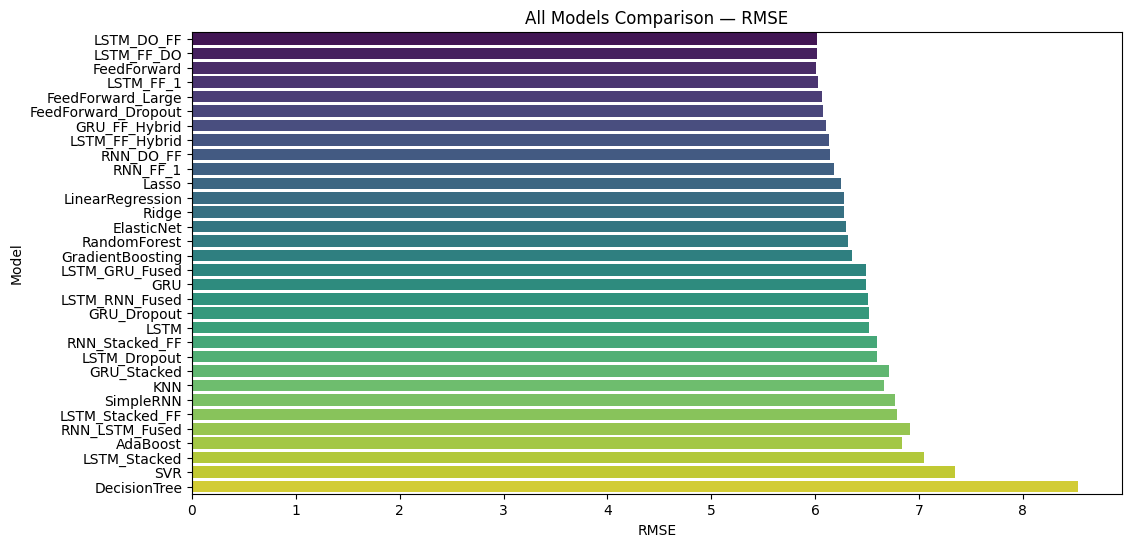

/tmp/ipython-input-3178187689.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="MAE", y="Model", data=all_results_df, palette="magma")


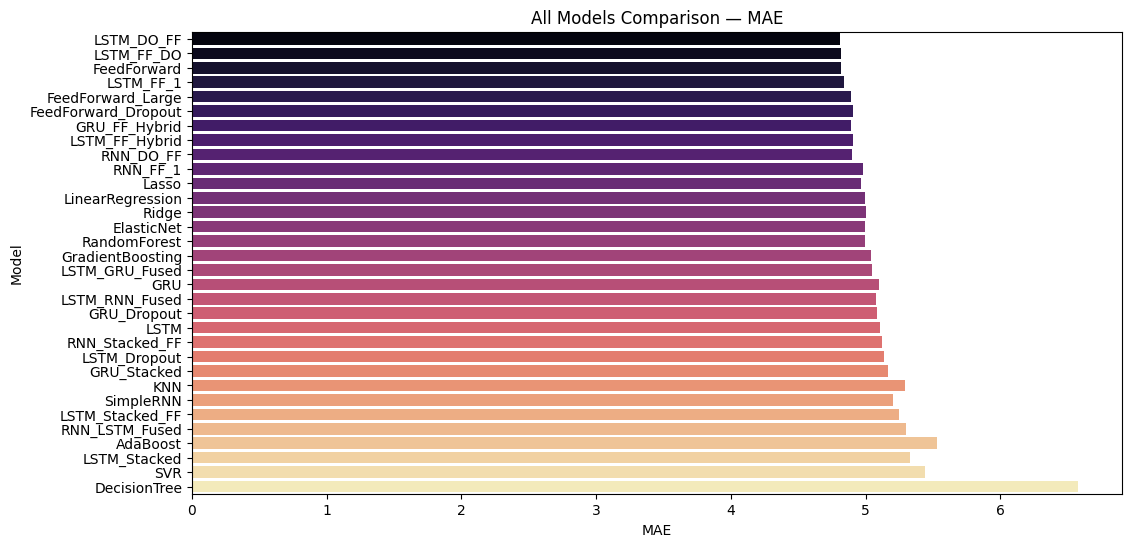

/tmp/ipython-input-3178187689.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Score", y="Model", data=all_results_df, palette="coolwarm")


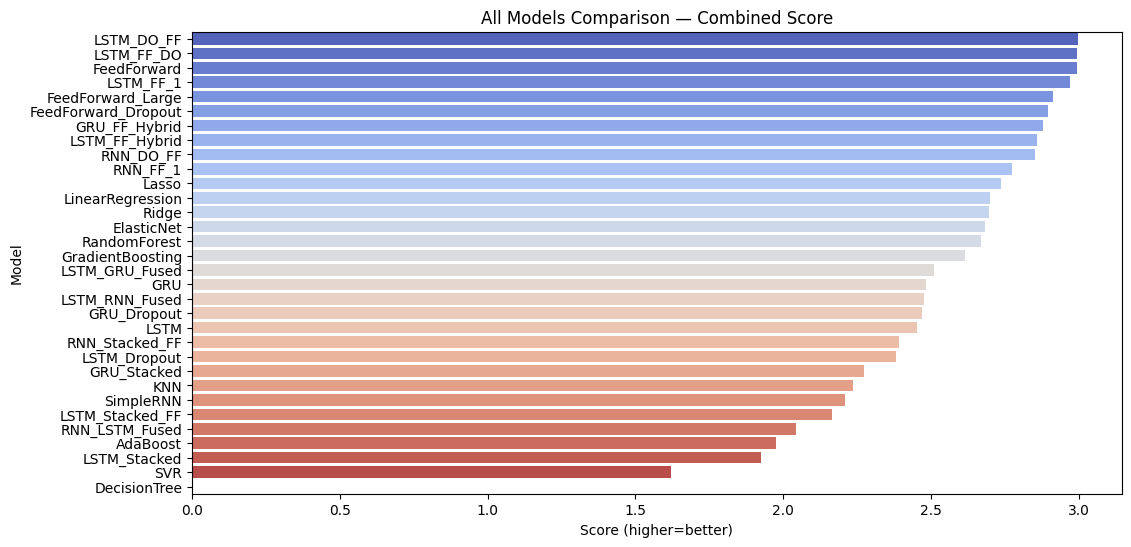

In [52]:
# 5️ Visualization

# a) RMSE comparison
plt.figure(figsize=(12,6))
sns.barplot(x="RMSE", y="Model", data=all_results_df, palette="viridis")
plt.title("All Models Comparison — RMSE")
plt.xlabel("RMSE")
plt.ylabel("Model")
plt.show()

# b) MAE comparison
plt.figure(figsize=(12,6))
sns.barplot(x="MAE", y="Model", data=all_results_df, palette="magma")
plt.title("All Models Comparison — MAE")
plt.xlabel("MAE")
plt.ylabel("Model")
plt.show()

# c) Combined Score comparison
plt.figure(figsize=(12,6))
sns.barplot(x="Score", y="Model", data=all_results_df, palette="coolwarm")
plt.title("All Models Comparison — Combined Score")
plt.xlabel("Score (higher=better)")
plt.ylabel("Model")
plt.show()
